# DRP Processing Notebook
Load the DRP slice, visualize the mean DRP, derive direction/mask maps, and locate peaks in a downsampled/blurred projection.

### Imports

In [1]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
import cv2

from src import ImagePack
from src.drp_direction import drp_direction_map, drp_mask_angle
from src.line_detection import hough_transform, find_hough_peaks


### Load images + DRP (2x2 angular slice)

In [2]:
images = ImagePack(angle_slice=(1, 1), data_root="data", config_path="exp_param.yaml")


loading images: 100%|██████████| 480/480 [00:00<00:00, 804.05it/s]


### Mean DRP plot

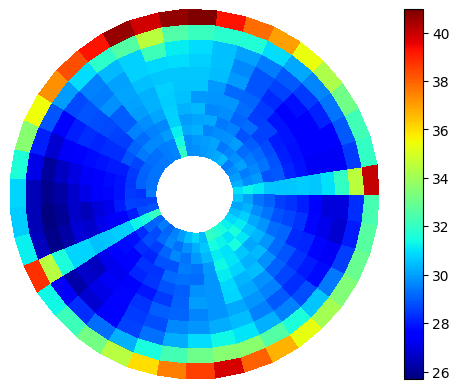

In [3]:
ax = images.plot_drp(images.get_mean_drp(), cmap="jet")
plt.show()


### Direction map + mask

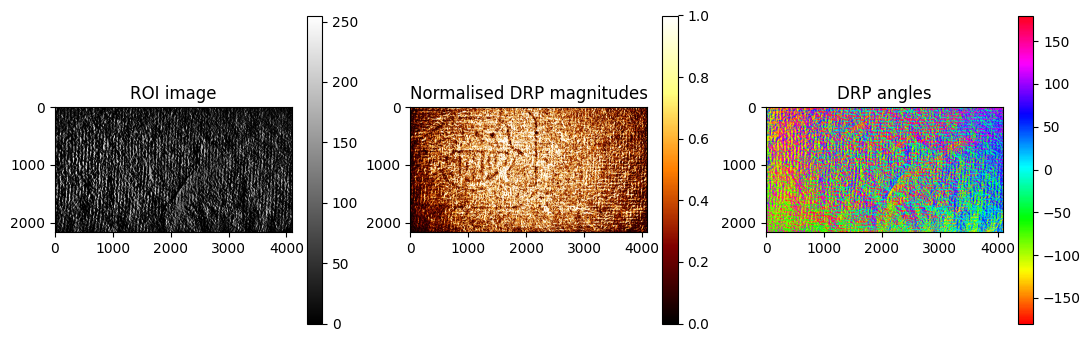

In [4]:
mag_map, deg_map = drp_direction_map(images)
img_mask = drp_mask_angle(mag_map, deg_map, orientation=90, threshold=45)


### Normalize orientation to 0-255 and show

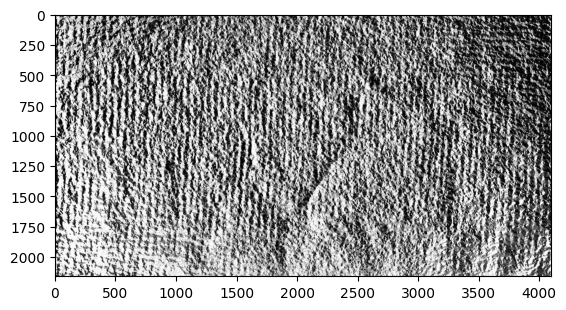

In [5]:
img = (0.5 * (-np.sin(np.radians(deg_map)) + 1) * 255).astype(np.uint8)
plt.imshow(img, cmap="gray")
plt.show()


### Downsample and blur

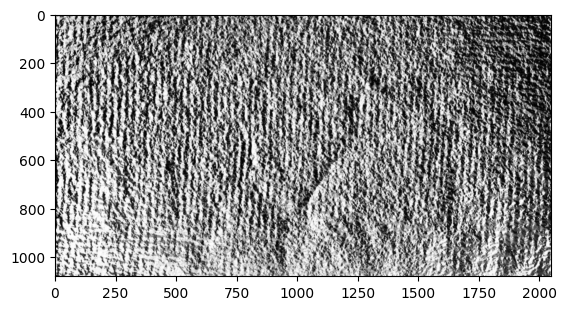

In [6]:
img_ds = img[::2, ::2]
img_blur = cv2.GaussianBlur(img_ds, (21, 21), sigmaX=1, sigmaY=1)
plt.imshow(img_blur, cmap="gray")
plt.show()


### Column intensity profile

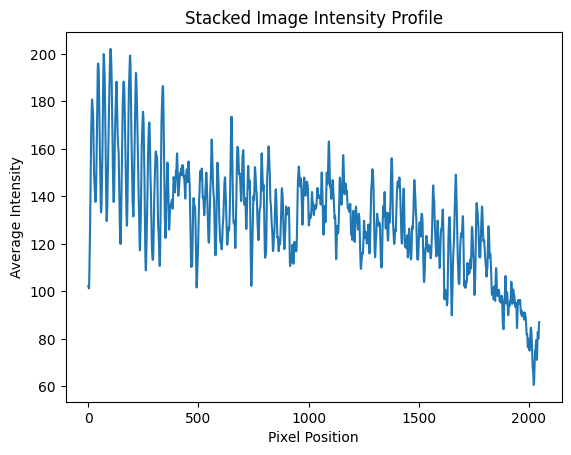

In [7]:
img_stacked = img_blur.mean(axis=0)
plt.plot(img_stacked)
plt.title("Stacked Image Intensity Profile")
plt.xlabel("Pixel Position")
plt.ylabel("Average Intensity")
plt.show()


### Peak detection and overlay

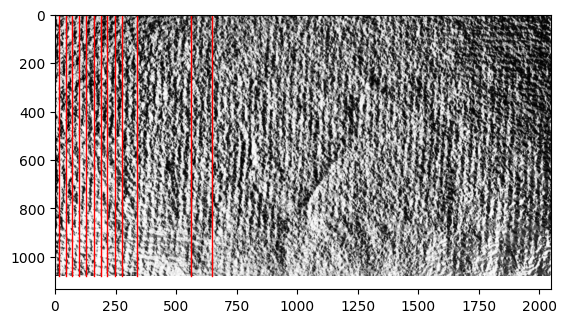

In [8]:
peaks, _ = scipy.signal.find_peaks(img_stacked)
peaks_by_height = peaks[np.argsort(img_stacked[peaks])[::-1]]
keep = 13
plt.imshow(img_blur, cmap="gray")
for peak in peaks_by_height[:keep]:
    plt.plot([peak, peak], [0, img_blur.shape[0]], color="red", linewidth=1)
plt.show()


Rotated image by 28.0 deg to align dominant line vertically.


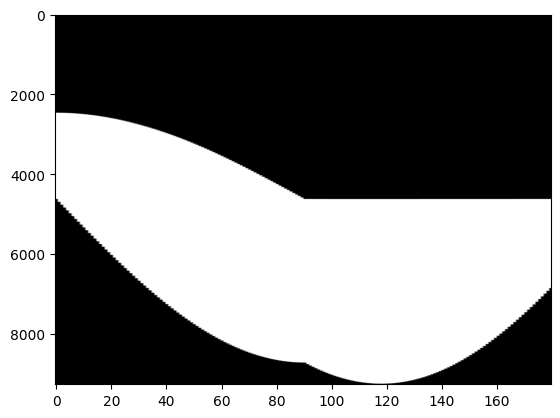

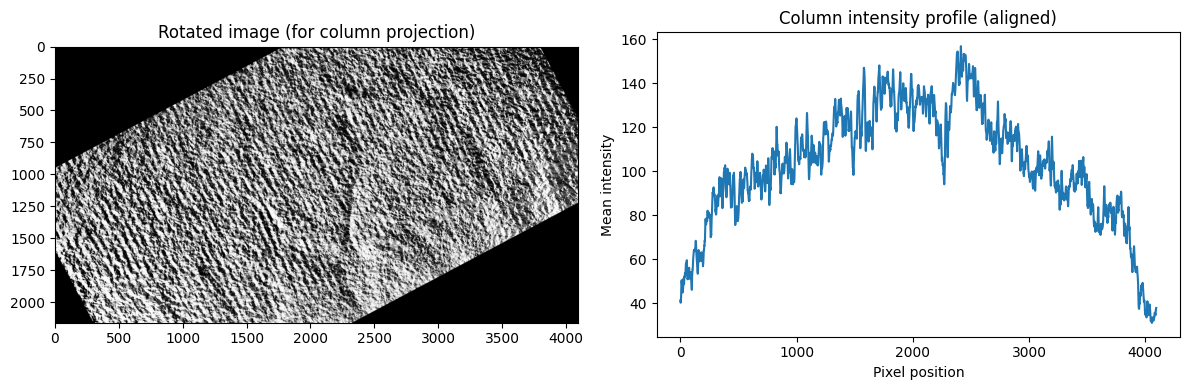

In [9]:
# Hough-based orientation alignment before column projection
from src.line_detection import hough_transform, dominant_orientation_from_accumulator, rotate_image_to_orientation

# Build edge map from the blurred DRP image (or other grayscale image)
edge_image = cv2.Canny(img, 50, 150)
plt.imshow(edge_image, cmap='gray')

acc, rhos, thetas = hough_transform(edge_image, rho_res=1, theta_res=1)

plt.imshow(acc, aspect='auto', cmap='afmhot')
dominant = dominant_orientation_from_accumulator(acc, thetas, top_k=1)
theta_rad = dominant[0][0] if dominant else None

if theta_rad is not None:
    rotated_img = rotate_image_to_orientation(img, theta_rad, target_angle_deg=0.0)
    print(f"Rotated image by {-np.degrees(theta_rad):.1f} deg to align dominant line vertically.")
else:
    rotated_img = img
    print("No dominant orientation found; using original image.")

# Column projection on the aligned image
aligned_profile = rotated_img.mean(axis=0)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(rotated_img, cmap='gray')
plt.title('Rotated image (for column projection)')
plt.subplot(1, 2, 2)
plt.plot(aligned_profile)
plt.title('Column intensity profile (aligned)')
plt.xlabel('Pixel position')
plt.ylabel('Mean intensity')
plt.tight_layout()
plt.show()
